In [5]:
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS=14
CHANNELS=3

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

There are 2152 images and they are divided into a batch of 32.Therefore the length of the dataset would be 68

In [9]:
for images,labels in dataset.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 256, 256, 3)
[2 0 1 1 1 1 1 1 1 1 2 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1]


To describe the shape (32, 256, 256, 3), we can break it down as follows:

The first dimension (32) represents the batch size, indicating that there are 32 images in the batch.
The second and third dimensions (256, 256) represent the height and width of each image, respectively.
The fourth dimension (3) represents the number of color channels in each image. In this case, it is 3, indicating that the images are in RGB format.
So, the shape (32, 256, 256, 3) describes a batch of 32 images, each with a height and width of 256 pixels, and 3 color channels.




[0 1 1 1 1 1 1 0 2 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 2 1 0 1 1 0 1 0]-->this indicates what all the 32 images are denoting: 
1->'Potato___Early_blight'..so on.

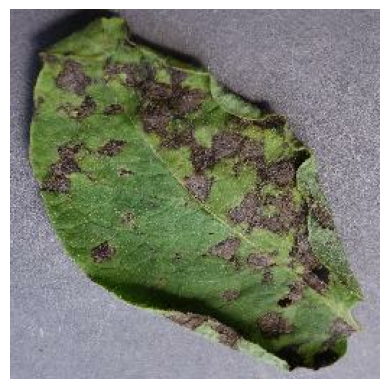

In [10]:
for images,labels in dataset.take(1):
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

80%-->training
10%-->Validation
10%-->testing


In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,validation_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(ds_size*train_split)
    val_size = int(ds_size*validation_split)
    test_size = int(ds_size*test_split)
    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [15]:
#Data Preprocessing

resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [16]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")  
     
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [18]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/14
54/54 [==============================] - 45s 834ms/step - loss: 0.7910 - accuracy: 0.6447 - val_loss: 0.7324 - val_accuracy: 0.6667
Epoch 2/14
54/54 [==============================] - 47s 872ms/step - loss: 0.5509 - accuracy: 0.7569 - val_loss: 0.5617 - val_accuracy: 0.7708
Epoch 3/14
54/54 [==============================] - 47s 873ms/step - loss: 0.4170 - accuracy: 0.8339 - val_loss: 0.4063 - val_accuracy: 0.8073
Epoch 4/14
54/54 [==============================] - 47s 863ms/step - loss: 0.3319 - accuracy: 0.8692 - val_loss: 0.2650 - val_accuracy: 0.8802
Epoch 5/14
54/54 [==============================] - 47s 863ms/step - loss: 0.2262 - accuracy: 0.9144 - val_loss: 0.2001 - val_accuracy: 0.9062
Epoch 6/14
54/54 [==============================] - 47s 874ms/step - loss: 0.2184 - accuracy: 0.9115 - val_loss: 0.1922 - val_accuracy: 0.8958
Epoch 7/14
54/54 [==============================] - 47s 862ms/step - loss: 0.1983 - accuracy: 0.9219 - val_loss: 0.1620 - val_accuracy: 0.9479

In [29]:
model.evaluate(test_ds)

8/8 [==============================] - 1s 131ms/step - loss: 0.3176 - accuracy: 0.8867


[0.317610502243042, 0.88671875]

In [30]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) ##creating a batch
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence
    

1/1 [==============================] - 0s 54ms/step


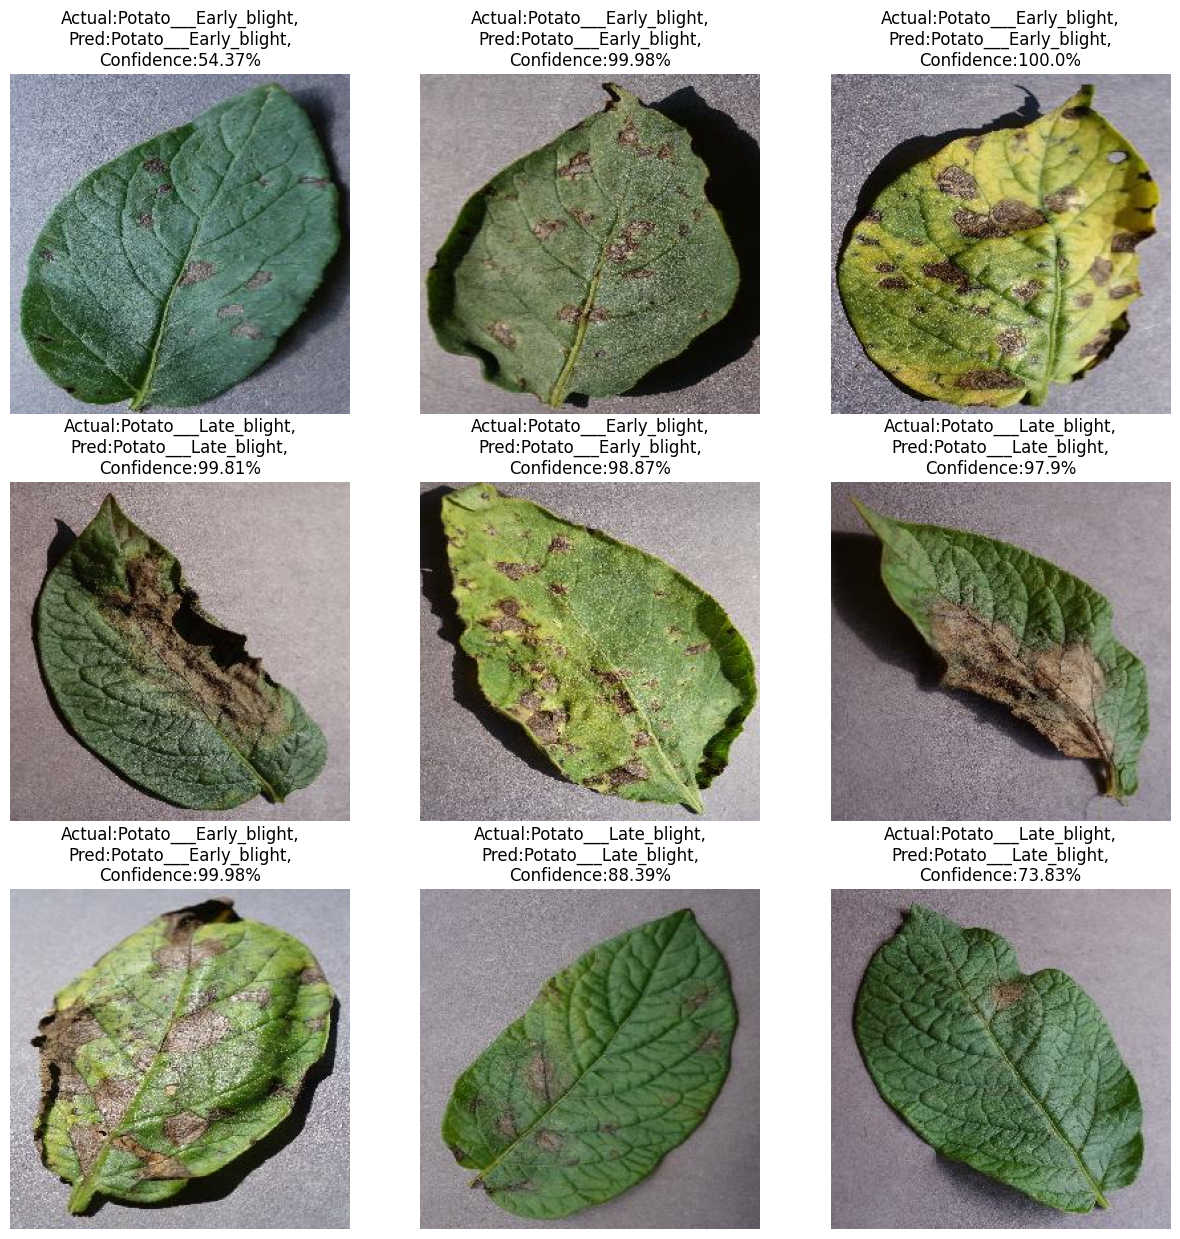

In [31]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\nPred:{predicted_class},\nConfidence:{confidence}%")
        plt.axis("off")

In [32]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
